### LSTM 单特征时间序列的分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### 下载数据

In [2]:
import os
import requests

DATASET_URL = 'https://raw.githubusercontent.com/ZhengDWu/NFSYSU-Wu-Zhan/master/dataset/dataset.csv' # the url of the dataset
DATASET_PATH = './datasets' # save path

def fetch_housing_data(dataset_url=DATASET_URL, dataset_path=DATASET_PATH):
    ''' Downloads file from the url and save it as filename '''
    # check if folder already exists
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    else:
        print("Folder exists")
    # check if file already exists
    dataset_file = os.path.join(dataset_path, "dataset.csv")
    if not os.path.isfile(dataset_file):
        print('Downloading File')
        response = requests.get(dataset_url)
        # Check if the response is ok (200)
        if response.status_code == 200:
            # Open file and write the content
            with open(dataset_file,'wb') as file:
                # A chunk of 128 bytes
                for chunk in response:
                    file.write(chunk)
            print('Download finish...')
    else:
        print('File exists')

fetch_housing_data()

Folder exists
File exists


### 导入数据

In [3]:
data_csv = pd.read_csv('./datasets/dataset.csv')

In [4]:
data_csv.head(10)

,Month,values
0,Jan-49,112
1,Feb-49,118
2,Mar-49,132
3,Apr-49,129
4,May-49,121
5,Jun-49,135
6,Jul-49,148
7,Aug-49,148
8,Sep-49,136
9,Oct-49,119


In [5]:
price = data_csv['values']

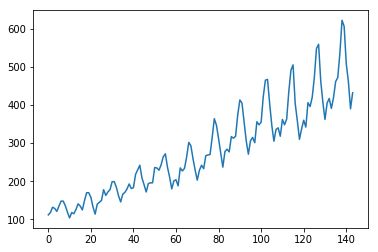

In [6]:
plt.plot(range(len(price)), price)

### data pre-processing

In [7]:
dataset = price.values.reshape(-1, 1) # 将 pandas 的数据 转为 numpy 的，然后再将 标量 变成 矩阵

In [8]:
dataset.shape

(144, 1)

### 对数据进行标准化，记住标准化后还要合并数据，后面再次切割 training set 和 testing set

In [9]:
# 对数据进行 标准化，将最后 百分之20，作为 测试集 
# 但是这里标准化后还是要合并，后续要给数据格式进行处理
train_size = int(len(dataset) * 0.8)
data_train = dataset[:train_size]
data_test = dataset[train_size:]

In [10]:
from sklearn.preprocessing import StandardScaler

standard = StandardScaler()
standard.fit(data_train)

data_train_standard = standard.transform(data_train)
data_test_standard = standard.transform(data_test)

# 合并
dataset_standard = np.concatenate((data_train_standard, data_test_standard), axis=0)
print('the shape of dataset_standard is: ', dataset_standard.shape)

the shape of dataset_standard is:  (144, 1)


c:\users\wuzhengdong\appdata\local\continuum\anaconda3\envs\wz\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\wuzhengdong\appdata\local\continuum\anaconda3\envs\wz\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\wuzhengdong\appdata\local\continuum\anaconda3\envs\wz\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### 过去 7 天来预测 今天 (look_back 这个参数可以自己调)

In [11]:
def create_dataset(dataset, look_back=7):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [12]:
data_X, data_Y = create_dataset(dataset_standard)

In [13]:
data_X.shape

(137, 7, 1)

In [14]:
data_Y.shape

(137, 1)

In [15]:
# 划分训练集和测试集，80% 作为训练集
train_size = int(len(data_X) * 0.8)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [16]:
import torch

train_x = torch.FloatTensor(train_X)
test_x = torch.FloatTensor(test_X)
train_y = torch.FloatTensor(train_Y)
test_y = torch.FloatTensor(test_Y)

In [17]:
print('the shape of train_x: ', train_x.size())
print('the shape of train_x: ', test_x.size())
print('the shape of train_x: ', train_y.size())
print('the shape of train_x: ', test_y.size())

the shape of train_x:  torch.Size([109, 7, 1])
the shape of train_x:  torch.Size([28, 7, 1])
the shape of train_x:  torch.Size([109, 1])
the shape of train_x:  torch.Size([28, 1])


In [18]:
from torch import nn
from torch.autograd import Variable

### 设置超参数

In [19]:
input_size = 1   # 输入数据 features 的个数
hidden_size = 32 # 隐藏层中神经元的个数
output_size = 1  # 输出神经元个数
num_layers = 1   # lstm 的层数
lr = 0.01        # 学习率
EPOCH = 5000

### 构建网络

In [20]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # rnn
        self.predict = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, (h,o) = self.rnn(x, None)
        # 将最后一个时间片扔进 Linear
        out = self.predict(x[:,-1,:])
        return out

In [21]:
rnn = LSTM()
rnn

LSTM(
  (rnn): LSTM(1, 32, batch_first=True)
  (predict): Linear(in_features=32, out_features=1, bias=True)
)

### 开始训练

In [22]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
loss_func = nn.MSELoss()

In [23]:
train_loss = []
test_loss = []

for epoch in range(EPOCH):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    
    out = rnn(var_x)
    trainloss = loss_func(out, var_y)

    optimizer.zero_grad()
    trainloss.backward()
    optimizer.step()
    
    
    if (epoch+1) % 50 == 0:
        train_loss.append(trainloss.data.numpy())
        print("Training.... ", 'Epoch: ', (epoch+1), 'loss: ', trainloss.data.numpy())
    
    # 使用测试集
    if (epoch+1) % 100 == 0:
        
        var_test_x = Variable(test_x)
        var_test_y = Variable(test_y)
        y_predict = rnn(var_test_x)
        testloss = loss_func(y_predict, var_test_y)
        test_loss.append(testloss)
        
        optimizer.zero_grad()
        testloss.backward()
        optimizer.step()
        
        print('Test ', 'Epoch: ', (epoch+1), 'Loss: ', testloss.data.numpy())

Training....  Epoch:  50 loss:  0.09002942
Training....  Epoch:  100 loss:  0.048526917
Test  Epoch:  100 Loss:  0.51181424
Training....  Epoch:  150 loss:  0.046853125
Training....  Epoch:  200 loss:  0.03247289
Test  Epoch:  200 Loss:  0.31766173
Training....  Epoch:  250 loss:  0.038417667
Training....  Epoch:  300 loss:  0.027375633
Test  Epoch:  300 Loss:  0.24807942
Training....  Epoch:  350 loss:  0.02908796
Training....  Epoch:  400 loss:  0.023585198
Test  Epoch:  400 Loss:  0.23413335
Training....  Epoch:  450 loss:  0.021565236
Training....  Epoch:  500 loss:  0.016539814
Test  Epoch:  500 Loss:  0.10416506
Training....  Epoch:  550 loss:  0.015751254
Training....  Epoch:  600 loss:  0.012876087
Test  Epoch:  600 Loss:  0.08016425
Training....  Epoch:  650 loss:  0.010696151
Training....  Epoch:  700 loss:  0.008925519
Test  Epoch:  700 Loss:  0.07159673
Training....  Epoch:  750 loss:  0.007650498
Training....  Epoch:  800 loss:  0.0058249757
Test  Epoch:  800 Loss:  0.0661

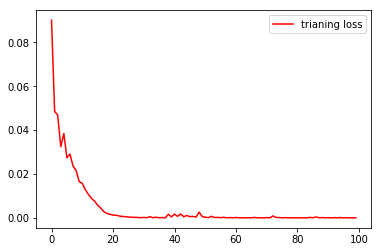

In [24]:
plt.plot(train_loss, 'r', label='trianing loss')
plt.legend()
plt.show()

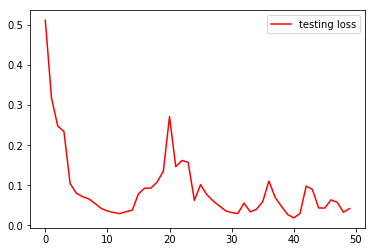

In [25]:
plt.plot(test_loss, 'r', label='testing loss')
plt.legend()
plt.show()

#### Variable to tensor to numpy

In [26]:
train_prediction = out.data.numpy()
test_prediction = y_predict.data.numpy()

In [27]:
# 合并
prediction = np.vstack((train_prediction, test_prediction))

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def calculate(y_true, y_predict):
    print('MAE: ', mean_absolute_error(y_true, y_predict))
    print('MSE: ', mean_squared_error(y_true, y_predict))
    print('RMSE: ', np.sqrt(mean_squared_error(y_true, y_predict)))
    print('R2: ', r2_score(y_true, y_predict))

In [29]:
print('标准化后的数据')
calculate(data_Y, prediction)

标准化后的数据
MAE:  0.03645578329220425
MSE:  0.008584818489057023
RMSE:  0.09265429557800882
R2:  0.9948421507406293


### 将所有数据都 反标准化

In [30]:
origin_dataset = standard.inverse_transform(data_Y)
origin_prediction = standard.inverse_transform(prediction)
print('the shape of origin_dataset: ', origin_dataset.shape)
print('the shape of origin_prediction: ', origin_prediction.shape)

the shape of origin_dataset:  (137, 1)
the shape of origin_prediction:  (137, 1)


In [31]:
print('反标准化变回原来数据:')
calculate(origin_dataset, origin_prediction)

反标准化变回原来数据:
MAE:  3.3156450925952328
MSE:  71.01240125004318
RMSE:  8.426885619850502
R2:  0.9948421507052588


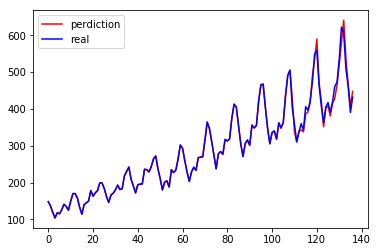

In [32]:
plt.plot(origin_prediction, 'r', label='perdiction')
plt.plot(origin_dataset, 'b', label='real')
plt.legend(loc='best')
plt.show()